**Installing Libraries**

In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import recall_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d ssismasterchief/machine-hack-fake-news-content-detection 

  0% 0.00/560k [00:00<?, ?B/s]
100% 560k/560k [00:00<00:00, 119MB/s]


In [3]:
!unzip machine-hack-fake-news-content-detection.zip

Archive:  machine-hack-fake-news-content-detection.zip
  inflating: Test.csv                
  inflating: Train.csv               
  inflating: sample submission.csv   


In [4]:
df = pd.read_csv("/content/Train.csv")
print(df.shape)

(10240, 3)


In [6]:
df

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"
...,...,...,...
10235,3,There are a larger number of shark attacks in ...,"animals,elections"
10236,3,Democrats have now become the party of the [At...,elections
10237,2,Says an alternative to Social Security that op...,"retirement,social-security"
10238,1,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy"


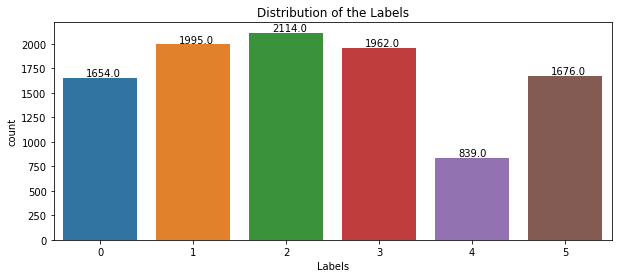

In [7]:
plt.figure(figsize = (10,4))
ax = sns.countplot(x="Labels", data=df)
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+15))
plt.title("Distribution of the Labels")
plt.show()

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
from nltk.corpus import stopwords
import string
from tqdm import tqdm
tqdm.pandas()

In [10]:
df['Original Text'] = df['Text']
print("Original text: ")

print(df['Text'][0])

Original text: 
Says the Annies List political group supports third-trimester abortions on demand.


In [11]:
df["Text"] = df["Text"].str.lower()

In [12]:
stopwords_ = set(stopwords.words('english'))

def stopwords_removal(text):
    return " ".join([word for word in str(text).split() if word not in stopwords_])

tqdm.pandas()
df['Text'] = df['Text'].progress_apply(lambda text: stopwords_removal(text))

100%|██████████| 10240/10240 [00:00<00:00, 224322.45it/s]


In [13]:
print("After removing stopwords: ")

print(df['Text'][0])

After removing stopwords: 
says annies list political group supports third-trimester abortions demand.


In [14]:
punctuations= list(string.punctuation)

def cleaning_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

df['Text'] = df['Text'].progress_apply(lambda text: cleaning_punctuations(text))

100%|██████████| 10240/10240 [00:00<00:00, 218184.78it/s]


In [15]:
print("After removing punctuations: ")

print(df['Text'][0])

After removing punctuations: 
says annies list political group supports thirdtrimester abortions demand


In [16]:
from wordcloud import WordCloud

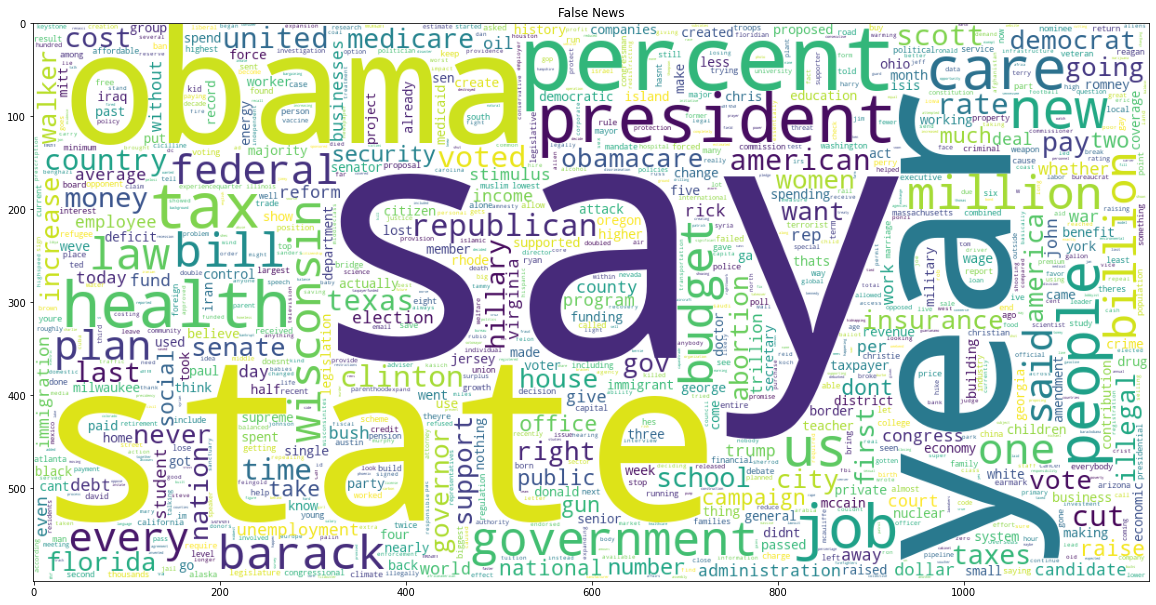

In [17]:
wc = WordCloud(background_color='white', max_words = 1000 , width = 1200 , height = 600, 
               collocations=False).generate(" ".join(df[df['Labels']==1]['Text']))
plt.figure(figsize = (20,20))
plt.title("False News")
plt.imshow(wc)

In [18]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [19]:
!pip install tensorflow-addons==0.8.3
!pip install tensorflow==2.2.0-rc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 31.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.0-rc3 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.0+zzzcolab20220506153740, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.4+zzzcolab20220516125453, 2.6.5, 2.6.5+zzzcolab20220523104206, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.0+zzzcolab20220506150900, 2.7.1, 2.7.2, 2.7.2+zzzcolab20220516114640, 2.7.3, 2.7.3+zzzcolab20220523111007, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.0+zzzcolab20220506162203, 2.8.1, 2.8.1+zzzcol

In [20]:
import tensorflow_addons as tfa

In [21]:
num_classes = (df['Labels'].nunique())

In [22]:
X = df['Text']
y = tf.keras.utils.to_categorical(df['Labels'], num_classes)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index

In [25]:
train_tokenizer

In [26]:
vocab_length = len(train_word_index) + 1
vocab_length

12075

In [27]:
train_sequences = train_tokenizer.texts_to_sequences(X_train)
len(train_sequences)

8192

In [28]:
test_sequences = train_tokenizer.texts_to_sequences(X_test)
len(test_sequences)

2048

In [29]:
maxlen=20
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')

In [30]:
embedding_dim = 6
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=maxlen),
    tf.keras.layers.SimpleRNN(64, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(32, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(16, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 6)             72450     
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 64)            4544      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 32)            3104      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 16)                784       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 6)                 1

In [31]:
history = model.fit(train_padded_seqeunces, y_train, epochs=20, validation_data=(test_padded_seqeunces, y_test))

Epoch 1/20
255/256 [============================>.] - ETA: 0s - loss: 1.7801 - f1_score: 0.1633

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


256/256 [==============================] - 16s 41ms/step - loss: 1.7800 - f1_score: 0.1633 - val_loss: 1.7619 - val_f1_score: 0.1362
Epoch 2/20
256/256 [==============================] - 10s 39ms/step - loss: 1.7396 - f1_score: 0.1885 - val_loss: 1.7778 - val_f1_score: 0.1337
Epoch 3/20
256/256 [==============================] - 10s 39ms/step - loss: 1.6311 - f1_score: 0.2696 - val_loss: 1.8463 - val_f1_score: 0.1642
Epoch 4/20
256/256 [==============================] - 10s 39ms/step - loss: 1.4279 - f1_score: 0.3727 - val_loss: 2.0358 - val_f1_score: 0.1712
Epoch 5/20
256/256 [==============================] - 10s 39ms/step - loss: 1.1806 - f1_score: 0.5172 - val_loss: 2.3383 - val_f1_score: 0.1676
Epoch 6/20
256/256 [==============================] - 10s 39ms/step - loss: 0.9561 - f1_score: 0.6328 - val_loss: 2.7251 - val_f1_score: 0.1713
Epoch 7/20
256/256 [==============================] - 10s 39ms/step - loss: 0.7536 - f1_score: 0.7291 - val_loss: 2.9473 - val_f1_score: 0.1733
Epo

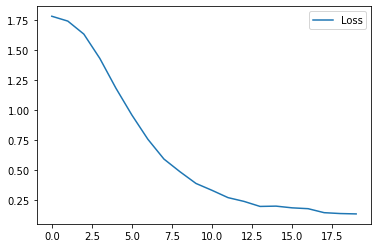

In [32]:
plt.plot(history.history['loss'], label='Loss')

plt.legend()
plt.show()

In [33]:
model.evaluate(test_padded_seqeunces, y_test)

64/64 [==============================] - 1s 16ms/step - loss: 5.3371 - f1_score: 0.1739


[5.337054252624512,
 array([0.14733543, 0.17198335, 0.21374047, 0.22276029, 0.11145511,
        0.17585693], dtype=float32)]

In [34]:
test_prob = model.predict(test_padded_seqeunces)
test_pred = np.where(test_prob > 0.5, 1, 0)

In [35]:
from sklearn.metrics import f1_score, log_loss, multilabel_confusion_matrix, plot_confusion_matrix
print("Log-Loss =", log_loss(y_test, test_prob))

Log-Loss = 5.337054486629697


In [36]:
print("F1-Score =", f1_score(y_test, test_pred, average = 'weighted'))

F1-Score = 0.1767441989695198


In [37]:
labels = ['Barely-True', 'False', 'Half-True', 'Mostly-True', 'Not-Known', 'True']

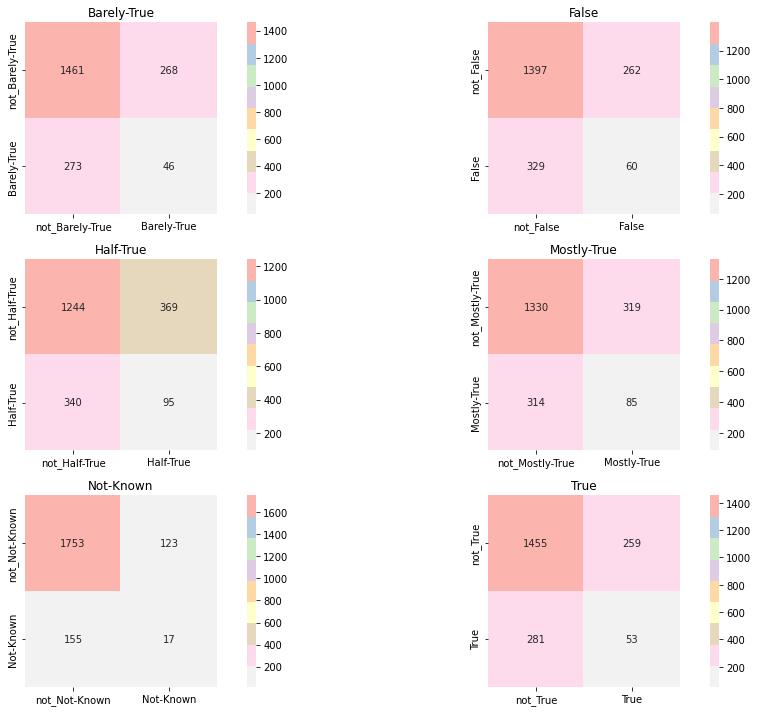

In [38]:
cm = multilabel_confusion_matrix(y_test, test_pred)
fig = plt.figure(figsize = (15, 10))
for i, (label, matrix) in enumerate(zip(labels, cm)):
    plt.subplot(3, 2, i+1)
    l = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, square = True, xticklabels = l, yticklabels = l, cmap='Pastel1_r', fmt='d')
    plt.title(label)
    
plt.tight_layout()
plt.show()